Loads data and generate plots for the paper:
1. summary plot fixation period 0-1000ms - number of units per area and number of trials per units (only trials with at least 1 spike per trial in fixation period)
2. firing rate 

In [2]:
import pickle
import numpy as np
import csv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from spike_train_utils import get_lv
os.chdir(current_wd)

In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
results_folder = project_folder_path + 'results\\monkey\\'
fig_folder = project_folder_path + 'results\\monkey\\fig_drafts_paper_reduce\\'

In [5]:
save_fig = False

### Load data

In [6]:
cut_interval_1000 = [0, 1000]
pfdl_n_trials_per_unit_merged_1000 = pd.read_pickle(results_folder + 'pfdl_n_trials_per_unit_fixation_' + str(cut_interval_1000[1]) + '.pkl')
pfp_n_trials_per_unit_merged_1000 = pd.read_pickle(results_folder + 'pfp_n_trials_per_unit_fixation_' + str(cut_interval_1000[1]) + '.pkl')

In [7]:
def load_spike_data(file_path):
    with open(file_path, newline='') as f:
        return list(csv.reader(f))
csv_files = {
    'pfdl': results_folder + 'data_pfdl_fixon_1000ms_no_empty_fixation.csv',
    'pfp': results_folder + 'data_pfp_fixon_1000ms_no_empty_fixation.csv'
}
spike_data = {area: load_spike_data(path) for area, path in csv_files.items()}

def get_fr_per_unit(sua_list):
    df = pd.DataFrame(sua_list)
    df = df.iloc[:, :5]  
    df.columns = ['unit_id', 'trial_id', 'condition_id', 'spike_count', 'fr_hz']
    df[['unit_id', 'fr_hz']] = df[['unit_id', 'fr_hz']].astype(float)

    # get lv
    lv_l = []
    for spike_train in sua_list:
        spike_train_int = np.asarray([int(spike) for spike in spike_train[5:]])
        lv = get_lv(spike_train_int, False)
        lv_l.append(lv)
    df['lv'] = lv_l

    df.dropna(inplace=True)
    
    rows_with_nans_df = df[df.isna().any(axis=1)]
    n_rows_with_nan = len(rows_with_nans_df)
    print(f'N rows with NaNs {n_rows_with_nan}')
    
    return df.groupby('unit_id', as_index=False)[['fr_hz', 'lv']].mean()

fr_mean_df = pd.concat(
    [get_fr_per_unit(spike_data[area]).assign(area=area) for area in spike_data]
).reset_index(drop=True)
fr_mean_df['fr_hz_log10'] = np.log10(fr_mean_df['fr_hz'])

N rows with NaNs 0
N rows with NaNs 0


In [ ]:
fr_mean_df

### Plots


#### Number of trials per neuron and number of neurons, fixation interval 0, 1000 ms

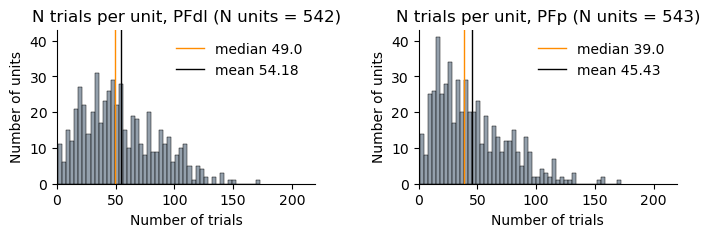

In [8]:
# plot
with_empty = False
n_trial_field = 'n_trials_with_empty' if with_empty else 'n_trials_no_empty'
fig_file_suffix = 'fixation_all_trials' if with_empty else 'fixation_no_empty_trials' 
fig_title_prefix = 'All trials from ' if with_empty else 'Only trials with at least 1 spike during '

n_units_pfdl_per_trials_1000 = len(pfdl_n_trials_per_unit_merged_1000.query('n_trials_with_empty > 0')) if with_empty \
else len(pfdl_n_trials_per_unit_merged_1000.query('n_trials_no_empty > 0'))

n_units_pfp_per_trials_1000 = len(pfp_n_trials_per_unit_merged_1000.query('n_trials_with_empty > 0')) if with_empty \
else len(pfp_n_trials_per_unit_merged_1000.query('n_trials_no_empty > 0'))

fig, axes = plt.subplots(1, 2, figsize=(8,2), gridspec_kw={'width_ratios': [2, 2]})
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.histplot(ax=axes[0], x=n_trial_field, data=pfdl_n_trials_per_unit_merged_1000, bins=50, stat='count', color='slategray')
sns.histplot(ax=axes[1], x=n_trial_field, data=pfp_n_trials_per_unit_merged_1000, bins=50, stat='count', color='slategray')
axes[0].sharey(axes[1])

axes[0].set_title('N trials per unit, PFdl (N units = ' + str(n_units_pfdl_per_trials_1000) + ')')
axes[1].set_title('N trials per unit, PFp (N units = ' + str(n_units_pfp_per_trials_1000) + ')')

axes[0].axvline(x=np.nanmedian(pfdl_n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='darkorange', 
                label='median ' + str(np.round(np.nanmedian(pfdl_n_trials_per_unit_merged_1000[n_trial_field].values), 2)))
axes[1].axvline(x=np.nanmedian(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='darkorange', 
                label='median ' + str(np.round(np.nanmedian(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), 2)))

axes[0].axvline(x=np.nanmean(pfdl_n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='black', label='mean ' 
                + str(np.round(np.nanmean(pfdl_n_trials_per_unit_merged_1000[n_trial_field].values), 2)))
axes[1].axvline(x=np.nanmean(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='black', label='mean ' 
                + str(np.round(np.nanmean(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), 2)))

for ax in axes.flat:
    ax.set_xlabel('Number of trials')
    ax.set_ylabel('Number of units')
    # ax.axvline(x=20, lw=1, color='red')
    ax.set_xlim([0, 220])
    ax.legend(frameon=False)

#fig.suptitle(fig_title_prefix + 'fixation period ([0,1000] are included', y=1.15)

sns.despine()

# if save_fig:
#     plt.savefig(fig_folder + 'dataset_unit_trials_count_' + fig_file_suffix + '_1000.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'dataset_unit_trials_count_' + fig_file_suffix + '_1000.svg' , bbox_inches='tight')

In [9]:
n_trials_per_unit_merged_1000 = pd.concat([pfdl_n_trials_per_unit_merged_1000, pfp_n_trials_per_unit_merged_1000])
n_trials_per_unit_merged_1000.reset_index(inplace=True, drop=True)
n_trials_per_unit_merged_1000

,unit_id,area,n_trials_with_empty,n_trials_no_empty
0,0,pfdl,92,92.0
1,1,pfdl,92,28.0
2,10,pfdl,81,81.0
3,100,pfdl,69,68.0
4,101,pfdl,102,76.0
...,...,...,...,...
1082,95,pfdl,119,44.0
1083,96,pfdl,118,14.0
1084,97,pfdl,95,94.0
1085,98,pfdl,37,12.0


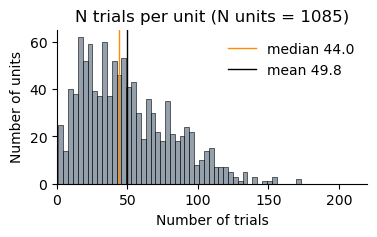

In [10]:
# plot
with_empty = False
n_trial_field = 'n_trials_with_empty' if with_empty else 'n_trials_no_empty'
fig_file_suffix = 'fixation_all_trials' if with_empty else 'fixation_no_empty_trials' 
fig_title_prefix = 'All trials from ' if with_empty else 'Only trials with at least 1 spike during '

n_units_pfdl_per_trials_1000 = len(n_trials_per_unit_merged_1000.query('n_trials_with_empty > 0')) if with_empty \
else len(n_trials_per_unit_merged_1000.query('n_trials_no_empty > 0'))

# n_units_pfp_per_trials_1000 = len(pfp_n_trials_per_unit_merged_1000.query('n_trials_with_empty > 0')) if with_empty \
# else len(pfp_n_trials_per_unit_merged_1000.query('n_trials_no_empty > 0'))

fig, axes = plt.subplots(1, 1, figsize=(4,2))

sns.histplot(ax=axes, x=n_trial_field, data=n_trials_per_unit_merged_1000, bins=50, stat='count', color='slategray')

axes.set_title('N trials per unit (N units = ' + str(n_units_pfdl_per_trials_1000) + ')')
# axes[1].set_title('N trials per unit, PFp (N units = ' + str(n_units_pfp_per_trials_1000) + ')')

axes.axvline(x=np.nanmedian(n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='darkorange', 
                label='median ' + str(np.round(np.nanmedian(n_trials_per_unit_merged_1000[n_trial_field].values), 2)))
# axes[1].axvline(x=np.nanmedian(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='darkorange', 
#                 label='median ' + str(np.round(np.nanmedian(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), 2)))

axes.axvline(x=np.nanmean(n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='black', label='mean ' 
                + str(np.round(np.nanmean(n_trials_per_unit_merged_1000[n_trial_field].values), 2)))
# axes[1].axvline(x=np.nanmean(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), lw=1, color='black', label='mean ' 
#                 + str(np.round(np.nanmean(pfp_n_trials_per_unit_merged_1000[n_trial_field].values), 2)))


axes.set_xlabel('Number of trials')
axes.set_ylabel('Number of units')
# ax.axvline(x=20, lw=1, color='red')
axes.set_xlim([0, 220])
axes.legend(frameon=False)

#fig.suptitle(fig_title_prefix + 'fixation period ([0,1000] are included', y=1.15)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'dataset_unit_trials_count_' + fig_file_suffix + '_1000_grouped.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'dataset_unit_trials_count_' + fig_file_suffix + '_1000_grouped.svg' , bbox_inches='tight')

In [11]:
n_trials_per_unit_merged_1000.describe()

,n_trials_with_empty,n_trials_no_empty
count,1087.000000,1085.000000
mean,83.731371,49.801843
std,29.901612,31.640981
min,18.000000,1.000000
25%,64.000000,24.000000
50%,85.000000,44.000000
75%,103.000000,70.000000
max,214.000000,173.000000


#### Firing rate, fixation interval 0, 1000 ms

In [12]:
fr_mean_df['fr_hz_log10'].describe()

count    1043.000000
mean        0.779671
std         0.223282
min         0.477121
25%         0.628389
50%         0.717855
75%         0.868088
max         1.621231
Name: fr_hz_log10, dtype: float64

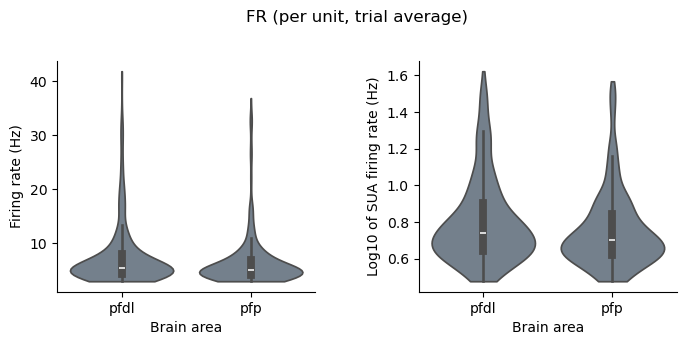

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(ax=axes[0], x='area', y='fr_hz', data=fr_mean_df, cut=0, density_norm='width', color='slategray')
sns.violinplot(ax=axes[1], x='area', y='fr_hz_log10', data=fr_mean_df, cut=0, density_norm='width', color='slategray')

axes[0].set_ylabel('Firing rate (Hz)')
axes[1].set_ylabel('Log10 of SUA firing rate (Hz)')

for ax in axes.flat:
    ax.set_xlabel('Brain area')

fig.suptitle('FR (per unit, trial average)', y=1.05)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'fr_fixation_no_empty_1000.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'fr_fixation_no_empty_1000.svg' , bbox_inches='tight')

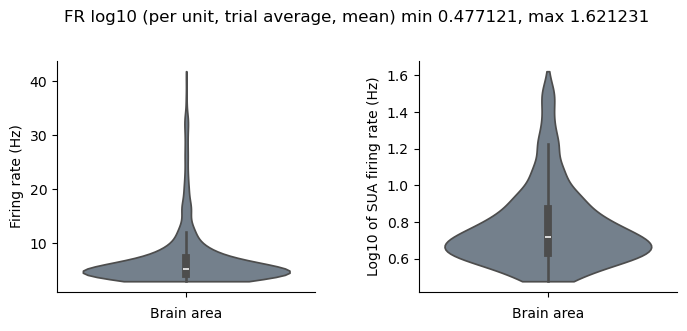

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(ax=axes[0], y='fr_hz', data=fr_mean_df, cut=0, density_norm='width', color='slategray')
sns.violinplot(ax=axes[1], y='fr_hz_log10', data=fr_mean_df, cut=0, density_norm='width', color='slategray')

axes[0].set_ylabel('Firing rate (Hz)')
axes[1].set_ylabel('Log10 of SUA firing rate (Hz)')

for ax in axes.flat:
    ax.set_xlabel('Brain area')

fig.suptitle(f'FR log10 (per unit, trial average, mean) min {0.477121}, max {1.621231}', y=1.05)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'fr_fixation_no_empty_1000_areas_together.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'fr_fixation_no_empty_1000_areas_together.svg' , bbox_inches='tight')

In [15]:
fr_mean_df.describe()

,unit_id,fr_hz,lv,fr_hz_log10
count,1043.000000,1043.000000,1043.000000,1043.000000
mean,270.267498,7.117856,0.889691,0.779671
std,158.429366,5.509021,0.412534,0.223282
min,0.000000,3.000000,0.010238,0.477121
25%,133.000000,4.250000,0.602916,0.628389
50%,269.000000,5.222222,0.838952,0.717855
75%,409.500000,7.380556,1.118912,0.868088
max,543.000000,41.805310,2.795632,1.621231


#### Lv

In [ ]:
fr_mean_df['lv'].describe()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(ax=axes[0], x='area', y='lv', data=fr_mean_df, cut=0, density_norm='width', color='slategray')

sns.kdeplot(
    data=fr_mean_df, 
    x="lv", 
    fill=True, 
    alpha=0.3,
    ax=axes[1]
)

axes[0].set_ylabel('Local variation (a.u.)')
axes[1].set_xlabel('Local variation (a.u.)')

fig.suptitle(f'Lv (per unit, trial average, mean) min {0.010238}, max {2.795632}', y=1.05)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'lv_fixation_no_empty_1000.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_fixation_no_empty_1000.svg' , bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(ax=axes[0], y='lv', data=fr_mean_df, cut=0, density_norm='width', color='slategray')
axes[0].axhline(y=1, lw=0.5, c='k')

sns.kdeplot(
    data=fr_mean_df, 
    x="lv", 
    fill=True, 
    alpha=0.3,
    ax=axes[1]
)

axes[0].set_ylabel('Local variation (a.u.)')
axes[1].set_xlabel('Local variation (a.u.)')

fig.suptitle(f'Lv (per unit, trial average, mean) min {0.010238}, max {2.795632}', y=1.05)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'lv_fixation_no_empty_1000_areas_together.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_fixation_no_empty_1000_areas_together.svg' , bbox_inches='tight')